# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
from matplotlib.ticker import MaxNLocator

from functions import train_model

In [2]:
# read in the json files
portfolio_raw = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile_raw = pd.read_json('data/profile.json', orient='records', lines=True)
transcript_raw = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data understanding



**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)


** -> Data is cleaned and ready to be used**

In [3]:
portfolio_raw

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
#portfolio_raw['duration']*24

In [4]:
portfolio_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


In [5]:
portfolio_raw['channels'].explode().unique()

array(['email', 'mobile', 'social', 'web'], dtype=object)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**-> the NoneType gender will be removed from profile dataset and storage in a new dataset**

In [6]:
profile_raw.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
profile_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [9]:
profile_raw.describe(include='all')

,gender,age,id,became_member_on,income
count,14825,17000.000000,17000,1.700000e+04,14825.000000
unique,3,NaN,17000,NaN,NaN
top,M,NaN,e4052622e5ba45a8b96b59aba68cf068,NaN,NaN
freq,8484,NaN,1,NaN,NaN
mean,NaN,62.531412,NaN,2.016703e+07,65404.991568
std,NaN,26.738580,NaN,1.167750e+04,21598.299410
min,NaN,18.000000,NaN,2.013073e+07,30000.000000
25%,NaN,45.000000,NaN,2.016053e+07,49000.000000
50%,NaN,58.000000,NaN,2.017080e+07,64000.000000
75%,NaN,73.000000,NaN,2.017123e+07,80000.000000


In [10]:
profile_raw['gender'].value_counts(dropna=False)

gender
M       8484
F       6129
None    2175
O        212
Name: count, dtype: int64

In [11]:
profile_raw[profile_raw['gender'].isna()]['age'].value_counts(dropna=False)

age
118    2175
Name: count, dtype: int64

In [12]:
profile_raw[profile_raw['gender'].isna()]['income'].value_counts(dropna=False)

income
NaN    2175
Name: count, dtype: int64

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [13]:
transcript_raw.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [14]:
transcript_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [15]:
transcript_raw['value']

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [16]:
transcript_raw['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [17]:
set([list(x.keys())[0] for x in transcript_raw['value']])

{'amount', 'offer id', 'offer_id'}

### Data Cleaning and Formatting Plan

#### **Objective**
- Clean and standardize the dataset while handling null values appropriately.

---

#### **Profile Dataset**
1. Split the `profile` dataset into two subsets:
   - One containing rows where the `gender` is `none`.
   - Another containing rows with all other `gender` values.

2. Convert the `became_member_on` column to a standardized **datetime** format for consistency and easier analysis.

---

#### **Portfolio Dataset**
- Update column names to make them more descriptive and easier to read.

---

#### **Transcript Dataset**
- Modify the keys within the `value` dictionaries by replacing spaces (`' '`) with underscores (`'_'`) to ensure uniformity and avoid potential issues in further processing.

---

In [3]:
#storage profiles with noneType gender values in separeted files
#profile_none = profile_raw[profile_raw['gender'].isna()].copy()
#profile = profile_raw[~profile_raw['gender'].isna()].copy()
profile = profile_raw.copy()




# changing the id GUIDs (Globally Unique Identifiers) to short tag.
port_id = {
    'ae264e3637204a6fb9bb56bc8210ddfd': 'ofr_A',
    '4d5c57ea9a6940dd891ad53e9dbe8da0': 'ofr_B',
    '3f207df678b143eea3cee63160fa8bed': 'ofr_C',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'ofr_D',
    '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'ofr_E',
    '2298d6c36e964ae4a3e7e9706d1fb8c2': 'ofr_F',
    'fafdcd668e3743c1bb461111dcafc2a4': 'ofr_G',
    '5a8bc65990b245e5a138643cd4eb9837': 'ofr_H',
    'f19421c1d4aa40978ebb69ca19b0e20d': 'ofr_I',
    '2906b810c7d4411798c6938adc9daaa5': 'ofr_J'
}



portfolio = portfolio_raw.copy()
portfolio['id_short'] = portfolio_raw['id'].map(port_id)

# Standardisation of column names
transcript = transcript_raw.copy()
transcript['event'] = transcript_raw['event'].str.replace(' ','_')

# Fixing the dicts key names
def fix_offer_id(value):
    if isinstance(value, dict) and 'offer id' in value:
        value['offer_id'] = value.pop('offer id')
    return value

transcript['value'] = transcript['value'].apply(fix_offer_id)


# creating a dataframe handling the data in 'value' column
value_df = pd.json_normalize(transcript['value']).fillna(0)
value_df['offer_id'] = value_df['offer_id'].map(port_id).fillna('tran')
transcript_b = pd.concat([transcript, value_df], axis=1).drop('value', axis=1)

# merging the transcript and profile dataframes
transcript_b = transcript_b.merge(profile_raw, left_on='person', right_on='id', how='left')

# mergin transcript and portfolio dataframes
transcript_b = transcript_b.merge(portfolio, left_on='offer_id', right_on='id_short', how='left', suffixes=('_x', '_std'))
transcript_b = transcript_b.drop(['id_x', 'reward_x', 'id_std', 'id_short'], axis=1)

transcript_b['became_member_on'] = pd.to_datetime(transcript_b['became_member_on'], format='%Y%m%d')
transcript_b['bec_memb_month'] = pd.to_datetime(transcript_b['became_member_on'], format='%Y%m%d').dt.strftime('%m')
transcript_b['bec_memb_day'] = pd.to_datetime(transcript_b['became_member_on'], format='%Y%m%d').dt.strftime('%d')
transcript_b['bec_memb_year_month'] = pd.to_datetime(transcript_b['became_member_on'], format='%Y%m%d').dt.strftime('%Y-%m')



#removing 'transactions' from the transcript_b dataframe
transactions = transcript_b.loc[transcript_b['event'] == 'transaction',:].dropna(axis=1)
transcript_gender_null = transcript_b.loc[(transcript_b['gender'].isna() & (transcript_b['event'] != 'transaction')),:]
transcript_b = transcript_b.loc[(~transcript_b['gender'].isna()) & (transcript_b['event'] != 'transaction'),:]

transcript_b

,person,event,time,offer_id,amount,gender,age,became_member_on,income,reward_std,channels,difficulty,duration,offer_type,bec_memb_month,bec_memb_day,bec_memb_year_month
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,ofr_D,0.0,F,75,2017-05-09,100000.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,05,09,2017-05
2,e2127556f4f64592b11af22de27a7932,offer_received,0,ofr_J,0.0,M,68,2018-04-26,70000.0,2.0,"[web, email, mobile]",10.0,7.0,discount,04,26,2018-04
5,389bc3fa690240e798340f5a15918d5c,offer_received,0,ofr_I,0.0,M,65,2018-02-09,53000.0,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,02,09,2018-02
7,2eeac8d8feae4a8cad5a6af0499a211d,offer_received,0,ofr_C,0.0,M,58,2017-11-11,51000.0,0.0,"[web, email, mobile]",0.0,4.0,informational,11,11,2017-11
8,aa4862eba776480b8bb9c68455b8c2e1,offer_received,0,ofr_E,0.0,F,61,2017-09-11,57000.0,5.0,"[web, email]",20.0,10.0,discount,09,11,2017-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306483,84fb57a7fe8045a8bf6236738ee73a0f,offer_viewed,714,ofr_H,0.0,F,64,2017-06-15,113000.0,0.0,"[email, mobile, social]",0.0,3.0,informational,06,15,2017-06
306490,abc4359eb34e4e2ca2349da2ddf771b6,offer_viewed,714,ofr_C,0.0,M,51,2014-08-04,68000.0,0.0,"[web, email, mobile]",0.0,4.0,informational,08,04,2014-08
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer_viewed,714,ofr_E,0.0,F,60,2017-09-08,64000.0,5.0,"[web, email]",20.0,10.0,discount,09,08,2017-09
306509,8431c16f8e1d440880db371a68f82dd0,offer_completed,714,ofr_G,0.0,M,39,2018-06-27,39000.0,2.0,"[web, email, mobile, social]",10.0,10.0,discount,06,27,2018-06


In [4]:
transcript_b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148805 entries, 0 to 306527
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   person               148805 non-null  object        
 1   event                148805 non-null  object        
 2   time                 148805 non-null  int64         
 3   offer_id             148805 non-null  object        
 4   amount               148805 non-null  float64       
 5   gender               148805 non-null  object        
 6   age                  148805 non-null  int64         
 7   became_member_on     148805 non-null  datetime64[ns]
 8   income               148805 non-null  float64       
 9   reward_std           148805 non-null  float64       
 10  channels             148805 non-null  object        
 11  difficulty           148805 non-null  float64       
 12  duration             148805 non-null  float64       
 13  offer_type         

In [5]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [6]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138953 entries, 12654 to 306533
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   person               138953 non-null  object        
 1   event                138953 non-null  object        
 2   time                 138953 non-null  int64         
 3   offer_id             138953 non-null  object        
 4   amount               138953 non-null  float64       
 5   age                  138953 non-null  int64         
 6   became_member_on     138953 non-null  datetime64[ns]
 7   bec_memb_month       138953 non-null  object        
 8   bec_memb_day         138953 non-null  object        
 9   bec_memb_year_month  138953 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 11.7+ MB


In [7]:
transcript_b['tag'] = (
    transcript_b.groupby(['person', 'event', 'offer_id'])
    .cumcount()
)

person_event = transcript_b.groupby(['person', 'event', 'offer_id', 'tag', 'gender', 'age', 'offer_type'], dropna=False).agg(
    cnt = ('event', 'count'),
    t = ('time', 'mean'),
    #age = ('age', 'max'),
    
    ).unstack([1]).fillna(np.inf).reset_index() #

person_event.columns = ['_'.join(col).strip('_') for col in person_event.columns.to_flat_index()]


person_event['to_vr'] = person_event['t_offer_viewed'] - person_event['t_offer_received']
person_event['to_cv'] = person_event['t_offer_completed'] - person_event['t_offer_viewed'] 
person_event['to_cr'] = person_event['t_offer_completed'] - person_event['t_offer_received']

person_event['curiosity_vr'] = (1 / (person_event['to_vr'] + 1)) * 100
person_event['eagerness_cv'] = (1 / ((person_event['to_cv']) + 1)) * 100
person_event['overall_cr'] = (1 / (person_event['to_cr'] + 1)) * 100

person_event['influence'] = ((person_event['t_offer_completed'] != 1000) & (person_event['t_offer_completed'] >= person_event['t_offer_viewed'])).astype(int) 
person_event['ext_influence'] = ((person_event['t_offer_viewed'] != 1000) & (person_event['t_offer_completed'] == person_event['t_offer_viewed'])).astype(int) 


df0 = person_event

for c in ['cnt_offer_completed', 'cnt_offer_received', 'cnt_offer_viewed']:
    df0[c] = df0[c].replace(np.inf, np.nan).fillna(0).astype(int)

df0 = df0.drop(columns=['t_offer_completed', 't_offer_viewed', 't_offer_received'])
df0 = df0.drop(columns=['to_vr', 'to_cv', 'to_cr'])
df0 = df0.round(1)



def categorize_age(age):
    if age < 25:
        return 'Young Adult'
    elif 25 <= age < 40:
        return 'Adult'
    elif 40 <= age < 60:
        return 'Middle-Aged'
    else:
        return 'Senior'
    
df0['age_group'] = df0['age'].apply(categorize_age)

df0.to_csv('person_activity_features.csv')


df0

,person,offer_id,tag,gender,age,offer_type,cnt_offer_completed,cnt_offer_received,cnt_offer_viewed,curiosity_vr,eagerness_cv,overall_cr,influence,ext_influence,age_group
0,0009655768c64bdeb2e877511632db8f,ofr_C,0,M,33,informational,0,1,1,2.7,0.0,0.0,1,0,Adult
1,0009655768c64bdeb2e877511632db8f,ofr_G,0,M,33,discount,1,1,1,2.7,-9.1,4.0,0,0,Adult
2,0009655768c64bdeb2e877511632db8f,ofr_H,0,M,33,informational,0,1,1,4.0,0.0,0.0,1,0,Adult
3,0009655768c64bdeb2e877511632db8f,ofr_I,0,M,33,bogo,1,1,1,2.0,-2.4,14.3,0,0,Adult
4,0009655768c64bdeb2e877511632db8f,ofr_J,0,M,33,discount,1,1,0,0.0,-0.0,100.0,0,0,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,ffff82501cea40309d5fdd7edcca4a07,ofr_E,0,F,45,discount,1,1,1,14.3,4.0,3.2,1,0,Middle-Aged
66497,ffff82501cea40309d5fdd7edcca4a07,ofr_G,0,F,45,discount,1,1,1,14.3,1.8,1.6,1,0,Middle-Aged
66498,ffff82501cea40309d5fdd7edcca4a07,ofr_J,0,F,45,discount,1,1,1,5.3,3.2,2.0,1,0,Middle-Aged
66499,ffff82501cea40309d5fdd7edcca4a07,ofr_J,1,F,45,discount,1,1,1,14.3,100.0,14.3,1,1,Middle-Aged


In [9]:
person_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66501 entries, 0 to 66500
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   person               66501 non-null  object 
 1   offer_id             66501 non-null  object 
 2   tag                  66501 non-null  int64  
 3   gender               66501 non-null  object 
 4   age                  66501 non-null  int64  
 5   offer_type           66501 non-null  object 
 6   cnt_offer_completed  66501 non-null  int64  
 7   cnt_offer_received   66501 non-null  int64  
 8   cnt_offer_viewed     66501 non-null  int64  
 9   t_offer_completed    66501 non-null  float64
 10  t_offer_received     66501 non-null  float64
 11  t_offer_viewed       66501 non-null  float64
 12  to_vr                66501 non-null  float64
 13  to_cv                55383 non-null  float64
 14  to_cr                66501 non-null  float64
 15  curiosity_vr         66501 non-null 

In [111]:
person_event['gender'].value_counts(dropna=False)

gender
M    38129
F    27456
O      916
Name: count, dtype: int64

In [38]:
event_age = transcript_b.groupby(['offer_id', 'gender', 'event']).agg(
    eve_cnt = ('event', 'count'),
    avg_t = ('time', 'mean'),
    avg_age = ('age', 'mean'),
    
    ).unstack([2]).round(1).reset_index()

event_age.columns = ['_'.join(col).strip('_') for col in event_age.columns.to_flat_index()]

event_age['com_rate'] = event_age.eve_cnt_offer_completed / event_age.eve_cnt_offer_received
event_age['view_rate'] = event_age.eve_cnt_offer_viewed / event_age.eve_cnt_offer_received
event_age['avg_t_diff']  = event_age.avg_t_offer_viewed - event_age.avg_t_offer_received

event_age


,offer_id,gender,eve_cnt_offer_completed,eve_cnt_offer_received,eve_cnt_offer_viewed,avg_t_offer_completed,avg_t_offer_received,avg_t_offer_viewed,avg_age_offer_completed,avg_age_offer_received,avg_age_offer_viewed,com_rate,view_rate,avg_t_diff
0,ofr_A,F,1857.0,2750.0,2364.0,396.5,329.6,353.4,58.4,57.7,57.0,0.675273,0.859636,23.8
1,ofr_A,M,1741.0,3840.0,3454.0,393.6,330.4,352.2,54.7,51.7,51.3,0.453385,0.899479,21.8
2,ofr_A,O,59.0,93.0,83.0,362.0,315.1,330.9,54.4,53.4,53.3,0.634409,0.892473,15.8
3,ofr_B,F,1746.0,2737.0,2623.0,383.8,333.6,351.7,58.3,57.6,57.6,0.637925,0.958349,18.1
4,ofr_B,M,1519.0,3784.0,3635.0,387.6,335.5,354.0,55.3,51.8,51.9,0.401427,0.960624,18.5
5,ofr_B,O,45.0,72.0,71.0,367.5,327.3,341.1,58.1,58.8,58.6,0.625000,0.986111,13.8
6,ofr_C,F,NaN,2749.0,1515.0,NaN,335.1,365.3,NaN,57.4,58.0,NaN,0.551109,30.2
7,ofr_C,M,NaN,3812.0,1902.0,NaN,330.8,358.1,NaN,52.5,54.4,NaN,0.498951,27.3
8,ofr_C,O,NaN,96.0,70.0,NaN,325.0,342.3,NaN,56.3,57.5,NaN,0.729167,17.3
9,ofr_D,F,1999.0,2767.0,1544.0,400.4,330.8,359.3,57.5,57.4,57.7,0.722443,0.558005,28.5


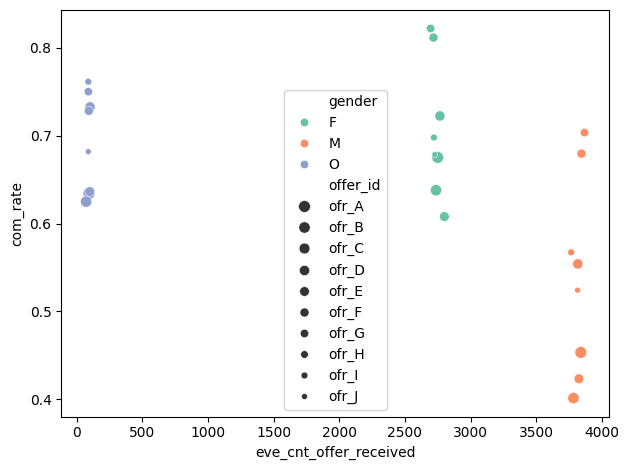

In [372]:
sns.scatterplot(data=event_age, x='eve_cnt_offer_received', y='com_rate', hue='gender', palette='Set2', size='offer_id') 	#
plt.tight_layout()

(0.0, 1.0)

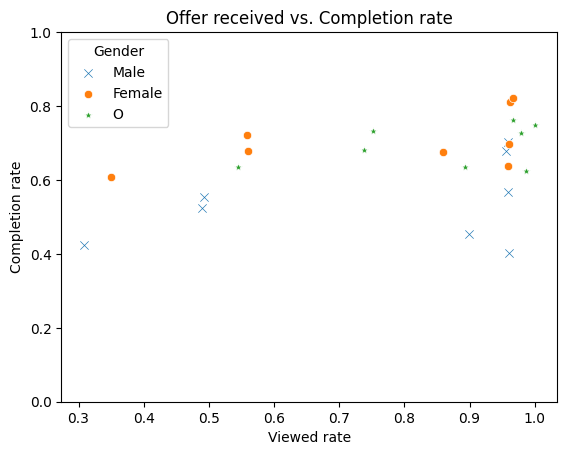

In [405]:
sns.scatterplot(data=event_age[event_age['gender'] == 'M'], x='view_rate', y='com_rate', marker='x') #, hue='offer_id', palette='Set2'
sns.scatterplot(data=event_age[event_age['gender'] == 'F'], x='view_rate', y='com_rate', marker='o')
sns.scatterplot(data=event_age[event_age['gender'] == 'O'], x='view_rate', y='com_rate', marker='*') #, , hue='offer_id'size='offer_id', palette='Set2'
plt.legend(title='Gender', labels=['Male', 'Female', 'O'])
plt.title('Offer received vs. Completion rate')
plt.xlabel('Viewed rate')   
plt.ylabel('Completion rate')

#plt.xlim(2500, 4000)
plt.ylim(0, 1)

In [399]:
event_age[event_age['offer_id'] == 'ofr_A']

,offer_id,gender,eve_cnt_offer_completed,eve_cnt_offer_received,eve_cnt_offer_viewed,avg_t_offer_completed,avg_t_offer_received,avg_t_offer_viewed,avg_age_offer_completed,avg_age_offer_received,avg_age_offer_viewed,com_rate,view_rate,avg_t_diff
0,ofr_A,F,1857.0,2750.0,2364.0,396.5,329.6,353.4,58.4,57.7,57.0,0.675273,0.859636,23.8
1,ofr_A,M,1741.0,3840.0,3454.0,393.6,330.4,352.2,54.7,51.7,51.3,0.453385,0.899479,21.8
2,ofr_A,O,59.0,93.0,83.0,362.0,315.1,330.9,54.4,53.4,53.3,0.634409,0.892473,15.8


(0.0, 1.1)

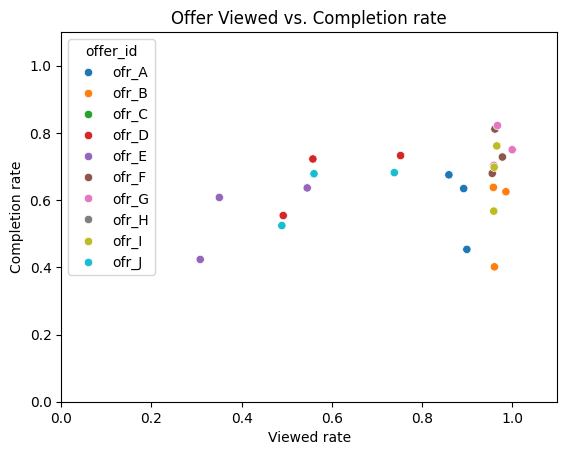

In [421]:
sns.scatterplot(
    data=event_age,
    x='view_rate',
    y='com_rate',
    hue='offer_id',  
    
)

plt.title('Offer Viewed vs. Completion rate')
plt.xlabel('Viewed rate')   
plt.ylabel('Completion rate')

plt.xlim(0,1.1)
plt.ylim(0,1.1)

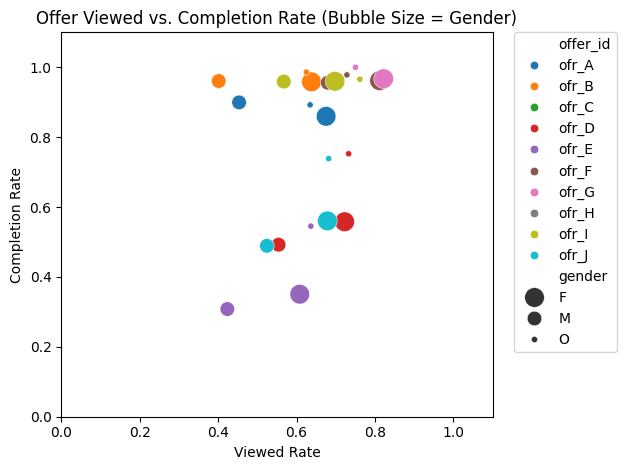

In [434]:
sns.scatterplot(
    data=event_age,
    y='view_rate',
    x='com_rate',
    hue='offer_id',
    size='gender',  
    sizes=(20, 200),
    legend='full',
)

# Configurar o título e rótulos
plt.title('Offer Viewed vs. Completion Rate (Bubble Size = Gender)')
plt.xlabel('Viewed Rate')
plt.ylabel('Completion Rate')
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)

# Ajustar a posição da legenda
plt.legend(
    bbox_to_anchor=(1.05, 1),  # Posição da legenda (à direita e acima)
    loc='upper left',         # Alinha no canto superior esquerdo da âncora
    borderaxespad=0           # Remove o espaçamento extra entre o gráfico e a legenda
)

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

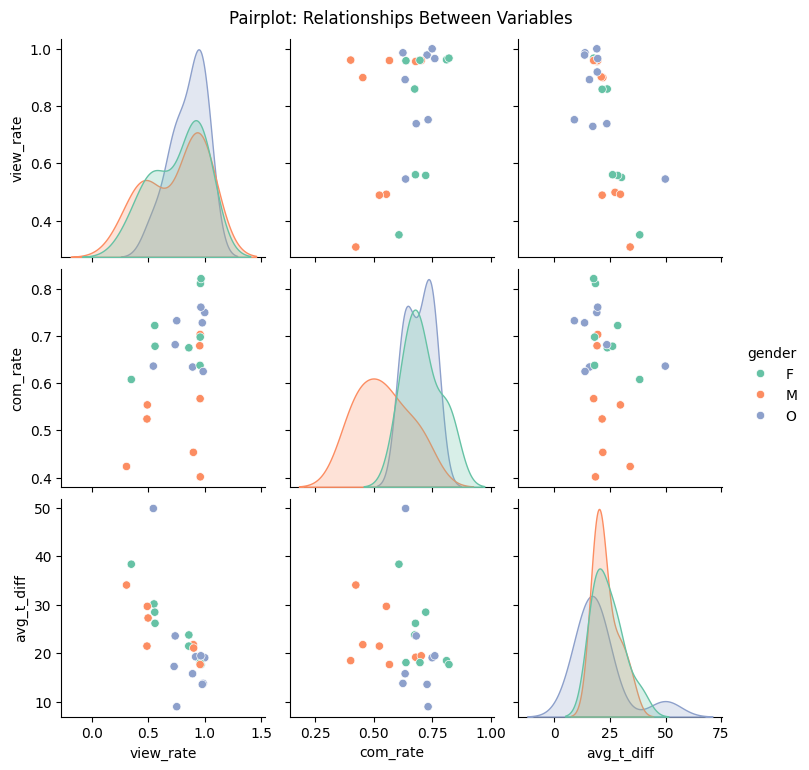

In [443]:
sns.pairplot(
    data=event_age, #[event_age['offer_id'] == 'ofr_G']
    vars=['view_rate', 'com_rate', 'avg_t_diff'],  # Substitua pelas métricas desejadas
    hue='gender',
    palette='Set2',
    diag_kind='kde',
)

plt.suptitle('Pairplot: Relationships Between Variables', y=1.02)
plt.show()

In [458]:
event_age[event_age['offer_id'] == 'ofr_G']

,offer_id,gender,eve_cnt_offer_completed,eve_cnt_offer_received,eve_cnt_offer_viewed,avg_t_offer_completed,avg_t_offer_received,avg_t_offer_viewed,avg_age_offer_completed,avg_age_offer_received,avg_age_offer_viewed,com_rate,view_rate,avg_t_diff
18,ofr_G,F,2216.0,2696.0,2608.0,394.0,332.4,350.1,58.2,57.8,57.9,0.821958,0.967359,17.7
19,ofr_G,M,2721.0,3868.0,3711.0,400.0,329.4,348.9,52.9,52.0,52.1,0.703464,0.959411,19.5
20,ofr_G,O,66.0,88.0,88.0,375.8,319.1,338.2,52.5,53.6,53.6,0.750000,1.000000,19.1


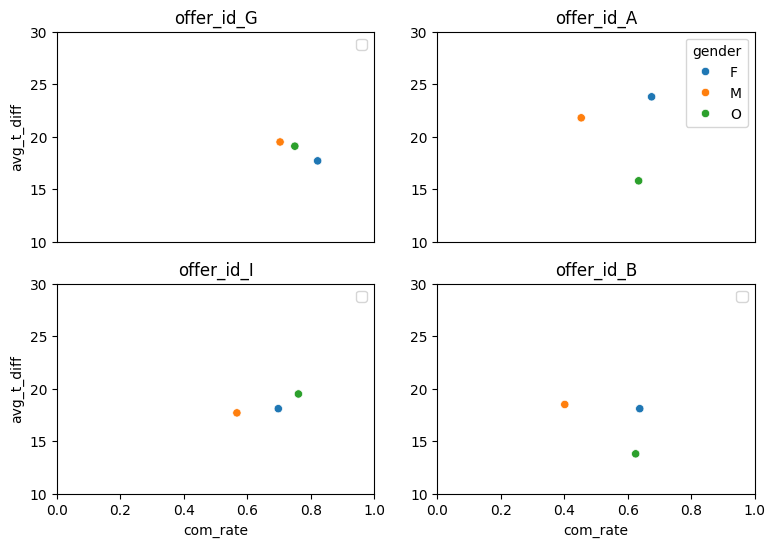

In [477]:
fig, axes = plt.subplots(2, 2, figsize=(9,6))  

sns.scatterplot(data=event_age[event_age['offer_id'] == 'ofr_G'], x='com_rate', y='avg_t_diff', ax=axes[0,0], hue='gender')
sns.scatterplot(data=event_age[event_age['offer_id'] == 'ofr_A'], x='com_rate', y='avg_t_diff', ax=axes[0,1], hue='gender')
sns.scatterplot(data=event_age[event_age['offer_id'] == 'ofr_I'], x='com_rate', y='avg_t_diff', ax=axes[1,0], hue='gender')
sns.scatterplot(data=event_age[event_age['offer_id'] == 'ofr_B'], x='com_rate', y='avg_t_diff', ax=axes[1,1], hue='gender')


axes[0,0].set_title('offer_id_G')
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('avg_t_diff')
axes[0,0].set_ylim(10, 30)
axes[0,0].set_xlim(0, 1) 
axes[0,0].legend('') 
axes[0,0].set_xticks([])

axes[0,1].set_title('offer_id_A')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')
axes[0,1].set_ylim(10, 30)
axes[0,1].set_xlim(0, 1)  
axes[0,1].set_xticks([])

axes[1,0].set_title('offer_id_I')
axes[1,0].set_xlabel('com_rate')
axes[1,0].set_ylabel('avg_t_diff')
axes[1,0].set_ylim(10, 30)
axes[1,0].set_xlim(0, 1)  
axes[1,0].legend('') 


axes[1,1].set_title('offer_id_B')
axes[1,1].set_xlabel('com_rate')
axes[1,1].set_ylabel('')
axes[1,1].set_ylim(10, 30)
axes[1,1].set_xlim(0, 1)  
axes[1,1].legend('') 

plt.show()


<Axes: xlabel='offer_id', ylabel='com_rate'>

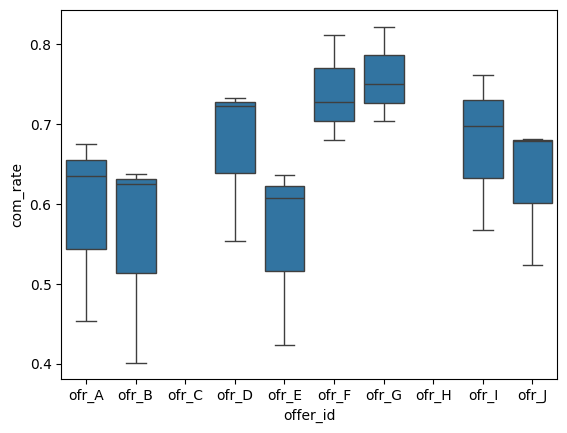

In [478]:
sns.boxplot(data=event_age, y='com_rate', x='offer_id') #, inner='quartile'

<Axes: xlabel='offer_id', ylabel='view_rate'>

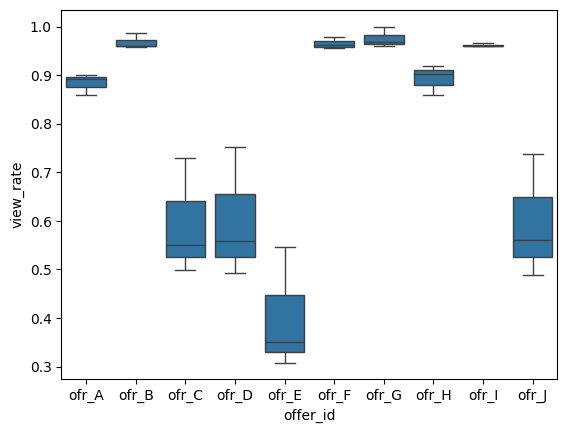

In [479]:
sns.boxplot(data=event_age, y='view_rate', x='offer_id')

<Axes: xlabel='avg_age_offer_completed', ylabel='Count'>

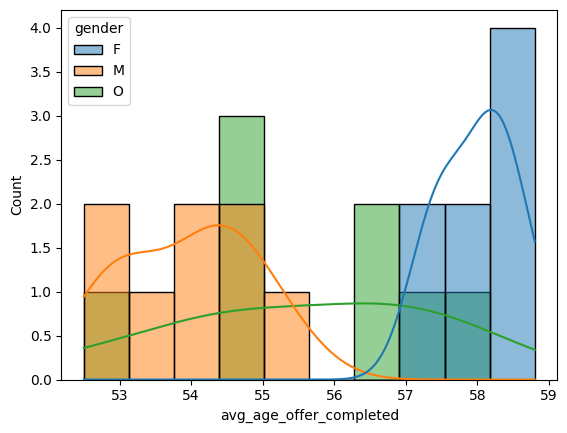

In [506]:
sns.histplot(data=event_age, x='avg_age_offer_completed', hue='gender', bins=10, kde=True) #[event_age['offer_id'] == 'ofr_A']

<Axes: xlabel='avg_age_offer_completed', ylabel='Count'>

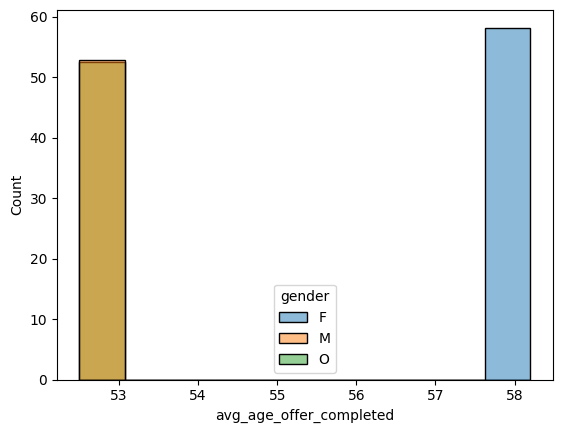

In [495]:
sns.histplot(data=event_age[event_age['offer_id'] == 'ofr_G'], x='avg_age_offer_completed', hue='gender', bins=10, kde=True, weights='avg_age_offer_completed')

In [ ]:
offer_event = transcript_b.groupby(['offer_id', 'gender', 'event'])['event'].count().unstack(2).reset_index()

offer_event['com_rate'] = offer_event['offer_completed'] / offer_event['offer_received']
offer_event['vie_rate'] = offer_event['offer_viewed'] / offer_event['offer_received']


offer_event

event,offer_id,gender,offer_completed,offer_received,offer_viewed,com_rate,vie_rate
0,ofr_A,F,1857.0,2750.0,2364.0,0.675273,0.859636
1,ofr_A,M,1741.0,3840.0,3454.0,0.453385,0.899479
2,ofr_A,O,59.0,93.0,83.0,0.634409,0.892473
3,ofr_B,F,1746.0,2737.0,2623.0,0.637925,0.958349
4,ofr_B,M,1519.0,3784.0,3635.0,0.401427,0.960624
5,ofr_B,O,45.0,72.0,71.0,0.625000,0.986111
6,ofr_C,F,NaN,2749.0,1515.0,NaN,0.551109
7,ofr_C,M,NaN,3812.0,1902.0,NaN,0.498951
8,ofr_C,O,NaN,96.0,70.0,NaN,0.729167
9,ofr_D,F,1999.0,2767.0,1544.0,0.722443,0.558005


<Axes: xlabel='became_member_on', ylabel='Count'>

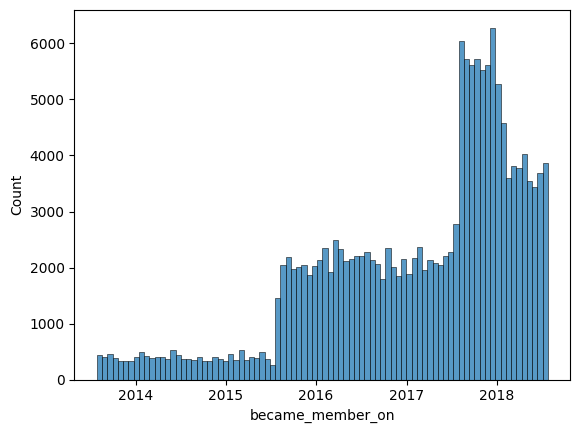

In [181]:
sns.histplot(data=transcript_b, x='became_member_on')

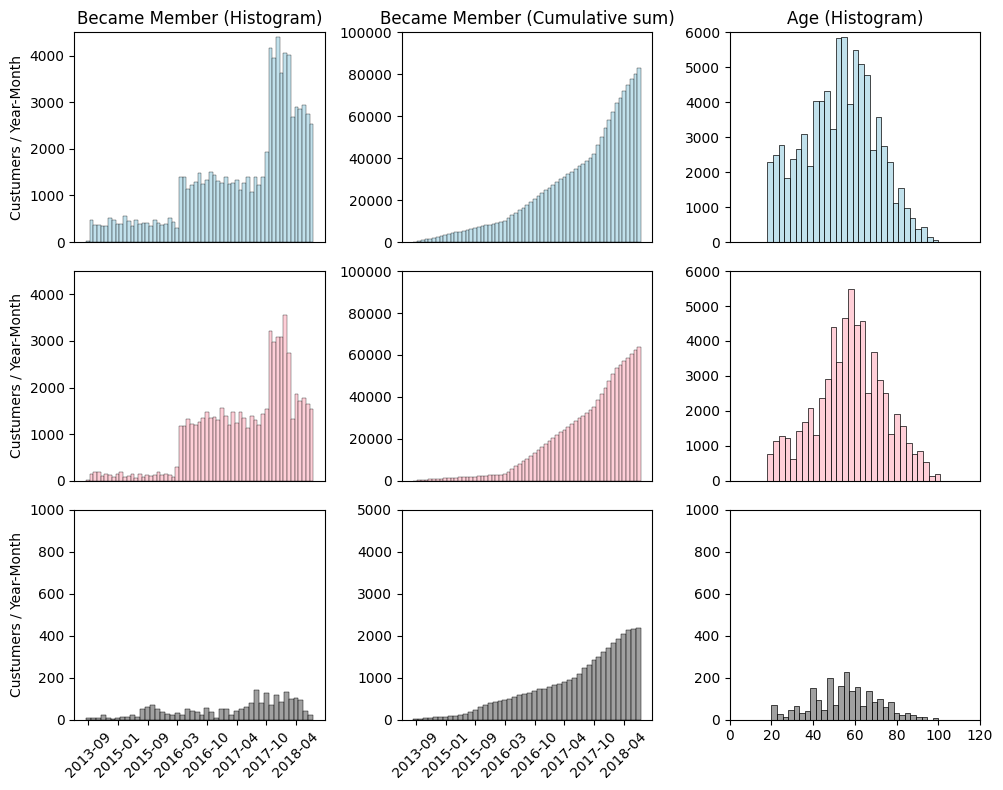

In [505]:
time_base = transcript_b.groupby(['bec_memb_year_month', 'gender']).agg(
    person_count=('person', 'count'),
).reset_index()

time_base['person_count_cumsum'] = time_base.groupby('gender')['person_count'].cumsum()

gender_age_base = transcript_b.loc[:, ['gender', 'age']]


fig, axes = plt.subplots(3, 3, figsize=(10, 8))  

sns.histplot(data=time_base[time_base['gender'] == 'M'], x='bec_memb_year_month',weights='person_count',  bins=10, color='lightblue',ax=axes[0,0])
sns.histplot(data=time_base[time_base['gender'] == 'F'],x='bec_memb_year_month',weights='person_count',  bins=10,  color='pink',ax=axes[1,0])
sns.histplot(data=time_base[time_base['gender'] == 'O'],x='bec_memb_year_month',weights='person_count',  bins=10,  color='grey',ax=axes[2,0])

sns.histplot(data=time_base[time_base['gender'] == 'M'], x='bec_memb_year_month',weights='person_count_cumsum',  bins=10, color='lightblue',ax=axes[0,1])
sns.histplot(data=time_base[time_base['gender'] == 'F'],x='bec_memb_year_month',weights='person_count_cumsum',  bins=10,  color='pink',ax=axes[1,1])
sns.histplot(data=time_base[time_base['gender'] == 'O'],x='bec_memb_year_month',weights='person_count_cumsum',  bins=10,  color='grey',ax=axes[2,1])

sns.histplot(data=gender_age_base[gender_age_base['gender'] == 'M']['age'], bins=30, color='lightblue', ax=axes[0,2])
sns.histplot(data=gender_age_base[gender_age_base['gender'] == 'F']['age'], bins=30, color='pink', ax=axes[1,2])
sns.histplot(data=gender_age_base[gender_age_base['gender'] == 'O']['age'], bins=30, color='grey', ax=axes[2,2])

axes[0,0].set_title('Became Member (Histogram)')
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Custumers / Year-Month')
axes[0,0].set_xticks([])
axes[0,0].set_ylim(0, 4500)  


axes[1,0].set_title('')
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('Custumers / Year-Month')
axes[1,0].set_xticks([])
axes[1,0].set_ylim(0, 4500)  


axes[2,0].set_title('')
axes[2,0].set_xlabel('')
axes[2,0].set_ylabel('Custumers / Year-Month')
axes[2,0].set_xticks([])
axes[2,0].set_ylim(0, 1000)  
axes[2,0].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))
axes[2,0].tick_params(axis='x', rotation=45)


axes[0,1].set_title('Became Member (Cumulative sum)')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')
axes[0,1].set_xticks([])
axes[0,1].set_ylim(0, 100000)  


axes[1,1].set_title('')
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('')
axes[1,1].set_xticks([])
axes[1,1].set_ylim(0, 100000)  


axes[2,1].set_title('')
axes[2,1].set_xlabel('')
axes[2,1].set_ylabel('')
#axes[2,1].set_xticks([])
axes[2,1].set_ylim(0, 5000)  
axes[2,1].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))
axes[2,1].tick_params(axis='x', rotation=45)


axes[0,2].set_title('Age (Histogram)')
axes[0,2].set_xlabel('')
axes[0,2].set_ylabel('')
axes[0,2].set_xticks([])
axes[0,2].set_ylim(0, 6000)  
axes[0,2].set_xlim(0, 120)  


axes[1,2].set_title('')
axes[1,2].set_xlabel('')
axes[1,2].set_ylabel('')
axes[1,2].set_xticks([])
axes[1,2].set_ylim(0, 6000)  
axes[1,2].set_xlim(0, 120)  

axes[2,2].set_title('')
axes[2,2].set_xlabel('')
axes[2,2].set_ylabel('')
#axes[2,2].set_xticks([])
axes[2,2].set_ylim(0, 1000)
axes[2,2].set_xlim(0, 120)    


# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.show()

#sns.barplot(data=time_base, y=time_base['person_count'], hue='bec_memb_year_month', palette='Set2')

In [213]:
transcript_b.loc[:, ['gender', 'age']]

,gender,age
0,F,75
1,None,118
2,M,68
3,None,118
4,None,118
...,...,...
306497,None,118
306506,None,118
306507,F,60
306509,M,39


In [160]:
time_base['person'].cumsum()

0         47
1        709
2       1285
3       1873
4       2320
       ...  
56    147170
57    152521
58    157945
59    163019
60    167581
Name: person, Length: 61, dtype: int64

In [79]:
# creating 'tag' column
transcript_b['tag'] = (
    transcript_b.groupby(['person', 'event', 'offer_id'])
    .cumcount()
)

(
transcript_b.pivot_table(
    index=['person', 'offer_id', 'tag'], 
    columns='event',
    values='time', 
    margins=False, 
    dropna=True).reset_index()
    
)


event,person,offer_id,tag,offer_completed,offer_received,offer_viewed
0,0009655768c64bdeb2e877511632db8f,ofr_C,0,NaN,336.0,372.0
1,0009655768c64bdeb2e877511632db8f,ofr_G,0,528.0,504.0,540.0
2,0009655768c64bdeb2e877511632db8f,ofr_H,0,NaN,168.0,192.0
3,0009655768c64bdeb2e877511632db8f,ofr_I,0,414.0,408.0,456.0
4,0009655768c64bdeb2e877511632db8f,ofr_J,0,576.0,576.0,NaN
...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,ofr_E,0,198.0,168.0,174.0
76273,ffff82501cea40309d5fdd7edcca4a07,ofr_G,0,60.0,0.0,6.0
76274,ffff82501cea40309d5fdd7edcca4a07,ofr_J,0,384.0,336.0,354.0
76275,ffff82501cea40309d5fdd7edcca4a07,ofr_J,1,414.0,408.0,414.0


event,person,offer_id,tag,offer_completed,offer_received,offer_viewed
0,0009655768c64bdeb2e877511632db8f,ofr_C,0,NaN,336.0,372.0
1,0009655768c64bdeb2e877511632db8f,ofr_G,0,528.0,504.0,540.0
2,0009655768c64bdeb2e877511632db8f,ofr_H,0,NaN,168.0,192.0
3,0009655768c64bdeb2e877511632db8f,ofr_I,0,414.0,408.0,456.0
4,0009655768c64bdeb2e877511632db8f,ofr_J,0,576.0,576.0,NaN
...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,ofr_E,0,198.0,168.0,174.0
76273,ffff82501cea40309d5fdd7edcca4a07,ofr_G,0,60.0,0.0,6.0
76274,ffff82501cea40309d5fdd7edcca4a07,ofr_J,0,384.0,336.0,354.0
76275,ffff82501cea40309d5fdd7edcca4a07,ofr_J,1,414.0,408.0,414.0


In [70]:
transcript_b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167581 entries, 0 to 306527
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   person            167581 non-null  object        
 1   event             167581 non-null  object        
 2   time              167581 non-null  int64         
 3   offer_id          167581 non-null  object        
 4   amount            167581 non-null  float64       
 5   gender            148805 non-null  object        
 6   age               167581 non-null  int64         
 7   became_member_on  167581 non-null  datetime64[ns]
 8   income            148805 non-null  float64       
 9   reward_std        167581 non-null  float64       
 10  channels          167581 non-null  object        
 11  difficulty        167581 non-null  float64       
 12  duration          167581 non-null  float64       
 13  offer_type        167581 non-null  object        
dtypes: dateti

In [69]:
transactions

,person,event,time,offer_id,amount,age,became_member_on
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,tran,0.83,20,2016-07-11
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,tran,34.56,42,2016-01-17
12659,54890f68699049c2a04d415abc25e717,transaction,0,tran,13.23,36,2017-12-28
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,tran,19.51,55,2017-10-16
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,tran,18.97,39,2017-12-17
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,tran,1.59,66,2018-01-01
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,tran,9.53,52,2018-04-08
306531,a00058cf10334a308c68e7631c529907,transaction,714,tran,3.61,63,2013-09-22
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,tran,3.53,57,2016-07-09


In [17]:
# cheking profile 
profile.describe(include='all').round(0) 

,gender,age,id,became_member_on,income
count,14825,14825.0,14825,14825,14825.0
unique,3,NaN,14825,NaN,NaN
top,M,NaN,e4052622e5ba45a8b96b59aba68cf068,NaN,NaN
freq,8484,NaN,1,NaN,NaN
mean,NaN,54.0,NaN,2017-02-18 12:30:15.419898880,65405.0
min,NaN,18.0,NaN,2013-07-29 00:00:00,30000.0
25%,NaN,42.0,NaN,2016-05-20 00:00:00,49000.0
50%,NaN,55.0,NaN,2017-08-02 00:00:00,64000.0
75%,NaN,66.0,NaN,2017-12-30 00:00:00,80000.0
max,NaN,101.0,NaN,2018-07-26 00:00:00,120000.0


In [18]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  int64         
 2   id                14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 694.9+ KB


In [19]:
# Checking the data transcript_b created
transcript_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    306534 non-null  object 
 1   event     306534 non-null  object 
 2   time      306534 non-null  int64  
 3   offer_id  306534 non-null  object 
 4   amount    306534 non-null  float64
 5   reward    306534 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


# Grouping/Merging Datasets and Features Engineering

**task:**
### Creating the `person_activity` Table: Customer Interaction Insights  

The goal is to construct the `person_activity` table to analyze customer behavior by tracking their event timelines and generating relevant time-based features.

This structured dataset enables detailed analysis of how customers interact with offers, their responsiveness, and purchasing behaviors over time.  

---

#### **Objective**  
Track and organize customer interactions (`person`, `event`, `offer_id`) into a structured `timeline`, generating features that offer insight into customer behavior.  

---

#### **Steps**  

1. **Create the `tag` column:**  
   - Enumerate unique combinations of `['person', 'event', 'offer_id']` to identify distinct events.  

2. **Group and unstack:**  
   - Group data by `person`, `offer_id`, and `tag`, and unstack the event timeline to create a structured timeline for customer interactions.  

3. **Merge Transaction Data:**  
   - Include transactional data by linking `time` and `amount` fields with the timeline structure.  

4. **Generate Count-Based Features:**  
   - Count key events (`offer_received`, `offer_viewed`, `offer_completed`) for each customer and offer.  
   - Add features to measure transaction-related behaviors such as the number of transactions.

5. **Calculate Time-Based Features:**  
   - Compute the time differences between events (`offer_received`, `offer_viewed`, and `offer_completed`) to assess responsiveness and engagement.  

6. **Behavioral Metrics:**  
   - Develop derived metrics to measure curiosity, eagerness, and overall responsiveness using the time differences.  

7. **Influence Indicators:**  
   - Identify whether customers were influenced by the offers based on the relationship between event timestamps.  

8. **Additional Features and Cleaning:**  
   - Compute average engagement time and handle missing values for transaction-related features like `amount` and `number of transactions`.  

---

#### **Outcome**  

The `person_activity` table will contain:  

1. **Timeline Events** for each `person` and `offer_id`:  
   - Key columns include `offer_received`, `offer_viewed`, and `offer_completed`.  

### Derived Features  

1. **Count-Based Features:**  
   - `n_rec`: Number of received offers.  
   - `n_vie`: Number of viewed offers.  
   - `n_com`: Number of completed offers.  
   - `n_tran`: Number of transactions.  
   - `amt_mean`: Average transaction amount.  

2. **Time-Based Metrics:**  
   - `to_vr`: Time between viewing and receiving an offer.  
   - `to_cv`: Time between completing and viewing an offer.  
   - `to_cr`: Time between completing and receiving an offer.  

3. **Behavioral Metrics:**  
   - `curiosity_vr`: Metric reflecting curiosity (based on time to view).  
   - `eagerness_cv`: Metric reflecting eagerness (based on time to complete).  
   - `overall_cr`: Overall responsiveness (based on time to complete after receiving).  

4. **Influence Indicators:**  
   - `ofr_influence`: Indicates if completion happened after viewing.  
   - `extrm_ofr_influence`: Indicates if completion occurred immediately after viewing.  



In [ ]:
# creating 'tag' column
transcript_b['tag'] = (
    transcript_b.groupby(['person', 'event', 'offer_id'])
    .cumcount()
)


# Group and unstack the transcript_b dataframe
person_activity = (
    transcript_b[transcript_b['event'] != 'transaction']
    .groupby(['person', 'offer_id', 'tag', 'event'])['time']
    .first()
    .unstack() #fill_value=5000
    .reset_index()
)

# Filtering the transcript_b dataframe to only include transactions
transactions = transcript_b.loc[transcript_b['event'] == 'transaction', ['person', 'time', 'amount']]


# Merge the person_activity dataframe with the transactions dataframe
person_activity = pd.merge(
    how='left',
    left=person_activity,
    right=transactions,
    left_on=['person', 'offer_completed'],
    right_on=['person', 'time'],
).drop(columns=['time'])


# Creating count features using the groupby() function and the agg() function. Merge the result with the person_activity dataframe
aggregations1 = person_activity.groupby(['person', 'offer_id']).agg(
    n_rec=('offer_received', 'count'),
    n_vie=('offer_viewed', 'count'),
    n_com=('offer_completed', 'count'),

).reset_index()

person_activity = person_activity.merge(aggregations1, on=['person', 'offer_id'], how='left')


aggregations2 = transcript_b[transcript_b['event'] == 'transaction'].groupby(['person', 'offer_id']).agg(
    n_tran = ('event', 'count'),
    amt_mean = ('amount', 'mean')

)

person_activity = person_activity.merge(aggregations2, on=['person'], how='left')


# Creating other features directly from the person_activity dataframe

person_activity['to_vr'] = person_activity['offer_viewed'] - person_activity['offer_received']
person_activity['to_cv'] = person_activity['offer_completed'] - person_activity['offer_viewed'] 
person_activity['to_cr'] = person_activity['offer_completed'] - person_activity['offer_received']

person_activity['curiosity_vr'] = (1 / (person_activity['to_vr'] + 1)) * 100
person_activity['eagerness_cv'] = (1 / (person_activity['to_cv'] + 1)) * 100
person_activity['overall_cr'] = (1 / (person_activity['to_cr'] + 1)) * 100

person_activity['ofr_influence'] = ((person_activity['offer_completed'] != 1000) & (person_activity['offer_completed'] >= person_activity['offer_viewed'])) 
person_activity['extrm_ofr_influence'] = ((person_activity['offer_viewed'] != 1000) & (person_activity['offer_completed'] == person_activity['offer_viewed']))

person_activity['avg_time_to_engage'] = ((person_activity['to_vr'] + person_activity['to_cv']) / 2)


person_activity.loc[:,'amount'] = person_activity.loc[:,'amount'].fillna(0)
person_activity.loc[:,'n_tran'] = person_activity.loc[:,'n_tran'].fillna(0)
person_activity.loc[:,'amt_mean'] = person_activity.loc[:,'amt_mean'].fillna(0)

person_activity = person_activity.round(2)

person_activity

In [ ]:
person_activity.info()

In [ ]:
person_activity[person_activity['person'] == 'ffff82501cea40309d5fdd7edcca4a07']

In [ ]:
# Group and unstack the transcript_b dataframe
offer_activity = (
    transcript_b[transcript_b['event'] != 'transaction']
    .groupby(['offer_id', 'event'])['time'].mean()
    .unstack() #fill_value=5000
    .reset_index()
)

offer_activity

In [ ]:
transcript_b

In [ ]:
profile

In [ ]:
transcript_gen = transcript_b.merge(profile, left_on='person', right_on='id', how='left')
transcript_gen = transcript_gen.drop(columns=['id'])

gender_activity = (
    transcript_gen[transcript_gen['event'] != 'transaction']
    .groupby(['gender', 'event'])['time'].mean()
    .unstack() #fill_value=5000
    .reset_index()
)

gender_activity['to_rv'] = gender_activity['offer_viewed'] - gender_activity['offer_received']
gender_activity['to_vc'] = gender_activity['offer_completed'] - gender_activity['offer_viewed']
gender_activity['to_rc'] = gender_activity['offer_completed'] - gender_activity['offer_received']


gender_activity.round(1)

In [ ]:
age_activity = (
    transcript_gen[transcript_gen['event'] != 'transaction']
    .groupby(['age', 'event'])['time'].mean()
    .unstack() #fill_value=5000
    .reset_index()
)

age_activity['to_rv'] = age_activity['offer_viewed'] - age_activity['offer_received']
age_activity['to_vc'] = age_activity['offer_completed'] - age_activity['offer_viewed']
age_activity['to_rc'] = age_activity['offer_completed'] - age_activity['offer_received']


age_activity.round(1)

In [ ]:
df = person_activity[(person_activity['offer_id'] == 'ofr_A')]

sns.histplot(df['offer_completed'], bins=30, kde=False, color='blue', label='To VR')
#sns.histplot(df['offer_received'], bins=30, kde=True, color='green', label='To CV')
#sns.histplot(df['offer_viewed'], bins=30, kde=True, color='orange', label='To CR')

plt.legend()
plt.title('Time Distribution for Completing Offers')
plt.xlabel('Time (in days)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
portfolio

In [ ]:
transcript_b

In [ ]:
transcript_b.groupby(['offer_id', 'event'])['person'].count().unstack().fillna(0).reset_index()

In [ ]:
offer_influence = (
    person_activity
    .groupby(['offer_id', 'ofr_influence'])['person'].count()
    .unstack(1)
    .reset_index()
    .fillna(0)
)

offer_influence['ofr_total'] = (offer_influence[True] + offer_influence[False])
offer_influence['inf_rate'] = offer_influence[True] / (offer_influence[True] + offer_influence[False])

offer_influence

In [ ]:
offer_influence = (
    person_activity
    .groupby(['offer_id', 'extrm_ofr_influence'])['person'].count()
    .unstack(1)
    .reset_index()
    .fillna(0)
)

offer_influence['ofr_total'] = (offer_influence[True] + offer_influence[False])
offer_influence['ext_inf_rate'] = offer_influence[True] / (offer_influence[True] + offer_influence[False])

offer_influence

In [ ]:
df4 = transcript_b[transcript_b['event'] == 'transaction'].groupby(['offer_id', 'time'])['person'].count().reset_index() #.unstack(1).fillna(0)
df4

In [ ]:
df4.plot(x='time', y='person')

In [ ]:
df = person_activity[(person_activity['offer_id'] == 'ofr_B')]

bins = int((714/24)//5)
sns.histplot(df['offer_completed'], bins=bins, kde=False, color='blue', label='To VR')
#sns.histplot(df['offer_received'], bins=30, kde=True, color='green', label='To CV')
#sns.histplot(df['offer_viewed'], bins=30, kde=True, color='orange', label='To CR')

plt.legend()
plt.title('Time Distribution for Completing Offers')
plt.xlabel('Time (in days)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
sns.scatterplot(data=person_activity, x='n_com', y='amount', hue='offer_id')
plt.title('Completion vs. Amount Spent')
plt.xlabel('Number of Offers Completed')
plt.ylabel('Total Amount Spent')
plt.show()


In [ ]:
correlation_matrix = person_activity[['n_rec', 'n_vie', 'n_com', 'amt_mean']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Metrics')
plt.show()


In [ ]:
plt.scatter(person_activity[person_activity['offer_id'] == 'ofr_A']['offer_received'], y=person_activity[person_activity['offer_id'] == 'ofr_A']['amount'])
plt.scatter(person_activity[person_activity['offer_id'] == 'ofr_A']['offer_viewed'], y=person_activity[person_activity['offer_id'] == 'ofr_A']['amount'])
plt.scatter(person_activity[person_activity['offer_id'] == 'ofr_A']['offer_completed'], y=person_activity[person_activity['offer_id'] == 'ofr_A']['amount'])

In [ ]:
grouped1 = transcript_b[transcript_b['event'] == 'offer_completed'].groupby(['person', 'offer_id'])
grouped2 = transcript_b[transcript_b['event'] == 'transaction'].groupby(['person', 'offer_id'])

aggregations1 = grouped1.agg(
    offer_fidelity=('event', 'count'),
    first_comp =('time', 'min'), 
    last_comp =('time', 'max'), 
).reset_index()

aggregations2 = grouped2.agg(
    fidelity_tran=('event', 'count'),
    first_time_tr=('time', 'min'),
    last_time_tr=('time', 'max')

).reset_index()

fidelity = pd.merge(
    how='left',
    left=aggregations1,
    right=aggregations2,
    on=['person']
).drop(columns=['offer_id_y'])


fidelity['recency'] = fidelity['first_time_tr'] <= 714
fidelity['recency_t1'] = fidelity['last_time_tr'] > 178.5*2
fidelity['recency_t2'] = fidelity['last_time_tr'] >= 178.5*3
fidelity['recency_t3'] = fidelity['last_time_tr'] >= 178.5*4


fidelity = fidelity.replace({True: 1, False: 0})

fidelity

In [ ]:
fidelity[(fidelity['last_time_tr'] > 178.5*2) & (fidelity['offer_id_x'] == 'ofr_A')]['person'].count()

In [ ]:
fidelity[(fidelity['last_time_tr'] > 178.5*2) & (fidelity['offer_id_x'] == 'ofr_B')]['person'].count()

In [ ]:
fidelity[(fidelity['last_time_tr'] > 178.5*2) & (fidelity['offer_id_x'] == 'ofr_C')]['person'].count()

In [ ]:
(178.5*4)/24

In [ ]:
fidelity[fidelity['recency_t3'] == 1]

In [ ]:
fidelity['recency'].sum()


In [ ]:
fidelity['recency_t1'].sum()

In [ ]:
fidelity['recency_t2'].sum()

In [ ]:
fidelity['recency_t3'].sum()

In [ ]:
fidelity_offer = fidelity[fidelity['offer_id_x'] == 'ofr_A']

pd.DataFrame([fidelity_offer['recency'].sum(),
fidelity_offer['recency_t1'].sum(),
fidelity_offer['recency_t2'].sum(),
fidelity_offer['recency_t3'].sum()]).plot(kind='bar')


In [ ]:
fidelity_offer = fidelity[fidelity['offer_id_x'] == 'ofr_B']

pd.DataFrame([fidelity_offer['recency'].sum(),
fidelity_offer['recency_t1'].sum(),
fidelity_offer['recency_t2'].sum(),
fidelity_offer['recency_t3'].sum()]).plot(kind='bar')

In [ ]:
178.5*4

In [ ]:
transcript_b['time'].unique()

In [ ]:
fidelity[['first_comp']].value_counts()

In [ ]:
fidelity.info()

In [234]:
def categorize_age(age):
    if age < 25:
        return 'Young Adult'
    elif 25 <= age < 40:
        return 'Adult'
    elif 40 <= age < 60:
        return 'Middle-Aged'
    else:
        return 'Senior'

# Aplicar a função ao DataFrame
tb_transactions['age_segment'] = tb_transactions['age'].apply(categorize_age)

In [ ]:
person_activity.dropna(axis=1)

In [38]:
df = person_activity
df = df.dropna()

X = df.drop(columns = ['person', 'event', 'became_member_on', 'gender', 'income'])
y = df['gender']

In [ ]:
y.value_counts()

In [ ]:
model1 = RandomForestClassifier(
    random_state=42,
    max_depth=15,
    n_estimators=25,
    min_samples_leaf=2,
    min_samples_split=2,
    #max_features=0.5,
    n_jobs=-1    
    )

model2 = DecisionTreeClassifier(
    random_state=42,
    criterion='entropy',            # Função de impureza para divisão ('gini' ou 'entropy')
    max_depth=15,                # Profundidade máxima da árvore (controle de overfitting)
    min_samples_split=2,         # Número mínimo de amostras para dividir um nó
    min_samples_leaf=2,          # Número mínimo de amostras em uma folha
    #max_features=5,           # Número máximo de features consideradas em cada divisão
    #splitter='random'            # Estratégia para escolher a divisão ('best' ou 'random')
    )



In [ ]:
model_type = model2
train_model(X, y, model_type)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Instanciar o modelo
rf = RandomForestClassifier(random_state=42)

# Definir a grade de parâmetros
param_grid = {
    'n_estimators': [50, 100, 200],        # Número de árvores na floresta
    'max_depth': [None, 10, 20, 30],       # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],       # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4],         # Número mínimo de amostras em uma folha
    'max_features': ['sqrt', 'log2'],      # Número de recursos considerados para divisão
    'bootstrap': [True, False]             # Amostragem com ou sem reposição
}

# Configurar o GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                  # Validação cruzada (5-fold)
    scoring='accuracy',    # Métrica de avaliação
    verbose=2,             # Nível de detalhe das mensagens
    n_jobs=-1              # Paralelização (usar todos os núcleos disponíveis)
)

# Ajustar o modelo aos dados de treino
grid_search.fit(X_train, y_train)

# Exibir os melhores parâmetros e a melhor pontuação
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor pontuação (treino):", grid_search.best_score_)

# Avaliar o modelo com os melhores parâmetros nos dados de teste
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Acurácia nos dados de teste:", test_accuracy)


y_pred_train = best_model.predict(X_train)
y_pred = best_model.predict(X_test)

# 1. Confusion Matrix
cm1 = confusion_matrix(y_train, y_pred_train)
cm2 = confusion_matrix(y_test, y_pred)


# 2. Relatório com Precision, Recall e F1-Score
report1 = classification_report(y_test, y_pred, target_names=best_model.classes_, zero_division=1)
print("Test Classification Report:")
print(report1)

report2 = classification_report(y_train, y_pred_train, target_names=best_model.classes_, zero_division=1)
print("Train Classification Report:")
print(report2)